In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Datengrundlage erstellen

In [3]:
products_source = pd.read_csv('data/products.csv')
stores_source   = pd.read_csv('data/stores.csv')
transaction_lines_test_source   = pd.read_parquet('data/transaction_lines_test_1.parquet')
transaction_lines_train_source  = pd.read_parquet('data/transaction_lines_train_1.parquet')
transactions_test_source        = pd.read_parquet('data/transactions_test_1.parquet')
transactions_train_source       = pd.read_parquet('data/transactions_train_1.parquet')

In [4]:
transactions_enriched = pd.merge(
    transactions_train_source,
    stores_source,
    left_on='store_id',
    right_on='id',
    how='left',
    suffixes=('', '_store')
)
# Drop the redundant 'id' column from the stores table after merge
transactions_enriched = transactions_enriched.drop(columns=['id_store'], errors='ignore')

In [5]:
lines_enriched = pd.merge(
    transaction_lines_train_source,
    products_source,
    left_on='product_id',
    right_on='id',
    how='left',
    suffixes=('', '_product')
)
# Drop the redundant 'id' column from the products table after merge
lines_enriched = lines_enriched.drop(columns=['id_product'], errors='ignore')

In [6]:
transactions_for_pipeline = transactions_enriched.copy()
transactions_for_pipeline = transactions_for_pipeline[transactions_for_pipeline['label'] != 'UNKNOWN']

In [7]:
transactions_for_pipeline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155692 entries, 2 to 1558199
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 155692 non-null  object        
 1   store_id           155692 non-null  object        
 2   cash_desk          155692 non-null  int64         
 3   transaction_start  155692 non-null  datetime64[us]
 4   transaction_end    155692 non-null  datetime64[us]
 5   total_amount       155692 non-null  float64       
 6   n_lines            155692 non-null  int64         
 7   payment_medium     155692 non-null  object        
 8   customer_feedback  10641 non-null   float64       
 9   damage             155692 non-null  float64       
 10  label              155692 non-null  object        
 11  opening_date       155692 non-null  object        
 12  location           155692 non-null  object        
 13  state              155692 non-null  object      

# Generator Klassen

In diesem Abschnitt definieren wir benutzerdefinierte Transformer-Klassen, die von `BaseEstimator` und `TransformerMixin` aus Scikit-learn erben. Diese Klassen kapseln spezifische Logiken zur Feature-Erstellung und -Transformation und können nahtlos in Scikit-learn Pipelines integriert werden. Dies fördert die Wiederverwendbarkeit und Strukturierung des Feature-Engineering-Prozesses.

- `TimeFeatureGenerator`: Extrahiert diverse zeitbasierte Merkmale aus Zeitstempelspalten (`transaction_start`, `transaction_end`). Dazu gehören einfache Zeiteinheiten, zyklische Transformationen (Sinus/Kosinus), binäre Indikatoren und Interaktionsmerkmale.
- `FeedbackBinnerOHE`: Verarbeitet die `customer_feedback`-Spalte. Fehlende Werte und spezifische Werte (z.B. 10.0) werden in diskrete Kategorien eingeteilt, welche anschließend mittels One-Hot-Encoding in numerische Features umgewandelt werden.

Beide Transformer implementieren die Methoden `fit`, `transform` und `get_feature_names_out`, um eine korrekte Integration in den `ColumnTransformer` von Scikit-learn zu gewährleisten.

In [8]:
class TimeFeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass # Keine Initialisierungsparameter notwendig

    def fit(self, X, y=None):
        # Dieser Transformer lernt keine Parameter aus den Daten.
        return self

    def transform(self, X, y=None):
        # Eingabe X: DataFrame mit 'transaction_start' und 'transaction_end'
        df_transformed = pd.DataFrame(index=X.index) # Erstellt eine Kopie mit dem ursprünglichen Index

        transaction_start = pd.to_datetime(X['transaction_start'])
        transaction_end = pd.to_datetime(X['transaction_end'])

        # --- Basis-Zeitmerkmale ---
        df_transformed['ft_month'] = transaction_start.dt.month
        df_transformed['ft_day'] = transaction_start.dt.day
        
        duration = transaction_end - transaction_start
        ft_duration_seconds_val = duration.dt.total_seconds()

        # --- Zyklische Zeit-basierte Features (aus transaction_start) ---
        df_transformed['ft_hour'] = transaction_start.dt.hour
        df_transformed['ft_minute'] = transaction_start.dt.minute
        df_transformed['ft_second'] = transaction_start.dt.second
        df_transformed['ft_day_of_week'] = transaction_start.dt.dayofweek # Montag=0, Sonntag=6
        df_transformed['ft_day_of_year'] = transaction_start.dt.dayofyear
        df_transformed['ft_week_of_year'] = transaction_start.dt.isocalendar().week.astype(int) # .week kann nullable sein
        df_transformed['ft_quarter'] = transaction_start.dt.quarter

        # --- Binäre/ereignisbasierte Features ---
        df_transformed['ft_is_weekend'] = df_transformed['ft_day_of_week'].isin([5, 6]).astype(int) # Samstag=5, Sonntag=6
        # Annahme: Normale Stunden sind 08:00 - 22:59 Uhr
        df_transformed['ft_is_outside_normal_hours'] = \
            ((df_transformed['ft_hour'] < 8) | (df_transformed['ft_hour'] >= 23)).astype(int)

        # --- Kodierung zyklischer Features (Sinus/Kosinus Transformation) ---
        df_transformed['ft_month_sin'] = np.sin(2 * np.pi * df_transformed['ft_month']/12)
        df_transformed['ft_month_cos'] = np.cos(2 * np.pi * df_transformed['ft_month']/12)

        df_transformed['ft_hour_sin'] = np.sin(2 * np.pi * df_transformed['ft_hour']/24)
        df_transformed['ft_hour_cos'] = np.cos(2 * np.pi * df_transformed['ft_hour']/24)

        df_transformed['ft_day_of_week_sin'] = np.sin(2 * np.pi * df_transformed['ft_day_of_week']/7)
        df_transformed['ft_day_of_week_cos'] = np.cos(2 * np.pi * df_transformed['ft_day_of_week']/7)

        days_in_year = transaction_start.dt.is_leap_year.map({True: 366, False: 365})
        df_transformed['ft_day_of_year_sin'] = np.sin(2 * np.pi * df_transformed['ft_day_of_year']/days_in_year)
        df_transformed['ft_day_of_year_cos'] = np.cos(2 * np.pi * df_transformed['ft_day_of_year']/days_in_year)
        
        # --- Transformation für ft_duration_seconds ---
        # Log-Transformation (np.log1p für Stabilität bei Werten nahe 0)
        df_transformed['ft_duration_seconds_log'] = np.log1p(ft_duration_seconds_val)

        # --- Interaktionsmerkmale ---
        df_transformed['ft_inter_weekend_outside_hours'] = \
            df_transformed['ft_is_weekend'] * df_transformed['ft_is_outside_normal_hours']
        df_transformed['ft_inter_hour_cos_x_dow_cos'] = \
            df_transformed['ft_hour_cos'] * df_transformed['ft_day_of_week_cos']
            
        # Speichert die Namen der generierten Features für get_feature_names_out.
        # Die Reihenfolge muss der Erstellung der Spalten entsprechen.
        self.feature_names_out_ = [
            'ft_month', 'ft_day', 
            'ft_hour', 'ft_minute', 'ft_second', 
            'ft_day_of_week', 'ft_day_of_year', 'ft_week_of_year', 'ft_quarter',
            'ft_is_weekend', 'ft_is_outside_normal_hours',
            'ft_month_sin', 'ft_month_cos',
            'ft_hour_sin', 'ft_hour_cos',
            'ft_day_of_week_sin', 'ft_day_of_week_cos',
            'ft_day_of_year_sin', 'ft_day_of_year_cos',
            'ft_duration_seconds_log', # Log-transformierte Dauer
            'ft_inter_weekend_outside_hours',
            'ft_inter_hour_cos_x_dow_cos'
        ]
        
        return df_transformed[self.feature_names_out_]

    def get_feature_names_out(self, input_features=None):
        # Gibt die Namen der erzeugten Features zurück.
        return self.feature_names_out_

In [9]:
class FeedbackBinnerOHE(BaseEstimator, TransformerMixin):
    """
    Benutzerdefinierter Transformer für die 'customer_feedback'-Spalte.
    1. Kategorisiert Feedback-Werte ('feedback_null', 'feedback_10', 'feedback_other').
    2. Führt One-Hot-Encoding für diese Kategorien durch (Präfix 'ft_').
    """
    def __init__(self):
        # Feste Kategorien und daraus resultierende Feature-Namen.
        self.categories_ = ['feedback_null', 'feedback_10', 'feedback_other']
        self.feature_names_out_ = [f"ft_{cat}" for cat in self.categories_]

    def fit(self, X, y=None):
        # Keine Anpassung an die Daten nötig, da Kategorien vordefiniert sind.
        return self

    def _categorize_feedback(self, feedback_value):
        # Interne Hilfsfunktion zur Kategorisierung.
        if pd.isnull(feedback_value):
            return 'feedback_null'
        elif feedback_value == 10.0:
            return 'feedback_10'
        else:  # Alle anderen nicht-null Werte (z.B. 1.0 bis 9.0)
            return 'feedback_other'

    def transform(self, X, y=None):
        # Eingabe X: DataFrame mit der 'customer_feedback'-Spalte.
        feedback_series = X.iloc[:, 0] # Extrahiert die relevante Spalte als Series.
        
        # Anwenden der Kategorisierungsfunktion.
        categorized_feedback = feedback_series.apply(self._categorize_feedback)
        
        # One-Hot-Encoding.
        # pd.Categorical stellt sicher, dass alle definierten Kategorien als Spalten erscheinen.
        categorized_feedback_type = pd.Categorical(categorized_feedback, categories=self.categories_)
        dummies_df = pd.get_dummies(categorized_feedback_type, prefix='ft', dtype=int)
        
        return dummies_df[self.feature_names_out_] # Gibt DataFrame mit Dummy-Variablen zurück.

    def get_feature_names_out(self, input_features=None):
        # Gibt die Namen der erzeugten Features zurück.
        return self.feature_names_out_

# 2. Definition von Zielvariable (y) und Merkmalsmatrix (X)

Bevor wir mit dem Training eines Modells beginnen können, müssen wir unsere Daten in zwei Hauptkomponenten aufteilen:
1.  **Zielvariable (y)**: Dies ist die Variable, die wir vorhersagen möchten. In diesem Fall ist es die Spalte `label`, die angibt, ob eine Transaktion als "FRAUD" oder "NORMAL" klassifiziert wird. Wir wandeln diese textuellen Bezeichnungen in numerische Werte (typischerweise 0 und 1 für binäre Klassifikation) um, damit Algorithmen des maschinellen Lernens sie verarbeiten können.
2.  **Merkmalsmatrix (X)**: Dies sind alle anderen Spalten in unserem Datensatz, die als Prädiktoren oder unabhängige Variablen dienen, um die Zielvariable vorherzusagen.

In den folgenden Schritten stellen wir sicher, dass die `label`-Spalte korrekt formatiert ist, führen die Umwandlung in numerische Werte durch und erstellen dann die finale Zielvariable `y` und die Merkmalsmatrix `X`.

In [10]:
# Sicherstellen, dass 'label' kategorial ist.
if not pd.api.types.is_categorical_dtype(transactions_for_pipeline['label']):
    transactions_for_pipeline['label'] = transactions_for_pipeline['label'].astype('category')

# Mappt 'label' auf numerische Werte (FRAUD: 1, NORMAL: 0).
y = transactions_for_pipeline['label'].map({'FRAUD': 1, 'NORMAL': 0})

# Prüft auf Mapping-Fehler (NaNs) und löst einen Fehler aus, falls welche vorhanden sind.
if y.isnull().any():
    raise ValueError(
        "Nicht alle Werte in 'label' konnten gemappt werden. "
        "Überprüfe die Kategorien (erwartet: 'FRAUD', 'NORMAL') und das Mapping."
    )

# Definiert die Merkmalsmatrix X durch Entfernen der 'label'-Spalte.
X = transactions_for_pipeline.drop('label', axis=1)

C:\Users\lol--\AppData\Local\Temp\ipykernel_25376\3674057655.py:2: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(transactions_for_pipeline['label']):


In [11]:
# # 1. Zielvariable (y) vorbereiten
# # Sicherstellen, dass 'label' eine kategorische Spalte ist, falls sie als String geladen wurde
# if not pd.api.types.is_categorical_dtype(transactions_for_pipeline['label']):
#     transactions_for_pipeline['label'] = transactions_for_pipeline['label'].astype('category')

# # Mapping für die Zielvariable: 'FRAUD' -> 1, 'NORMAL' -> 0
# try:
#     y = transactions_for_pipeline['label'].map({'FRAUD': 1, 'NORMAL': 0})
#     # Überprüfen, ob alle Werte gemappt wurden (keine NaNs durch fehlende Keys im Map)
#     if y.isnull().any():
#         raise ValueError("Nicht alle Werte in 'label' konnten gemappt werden. Überprüfe die Kategorien und das Mapping.")
# except Exception as e:
#     print(f"Fehler beim Mappen der 'label'-Spalte: {e}")
#     print("Stelle sicher, dass die Spalte 'label' nur 'FRAUD' und 'NORMAL' enthält oder passe das Mapping an.")
#     # Hier könntest du alternativ abbrechen oder einen Standardwert setzen, je nach Anforderung
#     # Für dieses Beispiel gehen wir davon aus, dass das Mapping erfolgreich ist oder korrigiert wird.
#     # y = pd.Series([0] * len(transactions_for_pipeline)) # Fallback, nicht empfohlen für Produktion

# # 2. Features (X) vorbereiten
# X = transactions_for_pipeline.drop('label', axis=1)

# 3. Aufbau des Preprocessors mittels ColumnTransformer

Nachdem die einzelnen Bausteine (benutzerdefinierte Transformer, Standard-Transformer) und die Logik zur Aufteilung der Daten definiert sind, setzen wir nun alles zu einer umfassenden Vorverarbeitungs-Pipeline zusammen. Hierfür verwenden wir den `ColumnTransformer` von Scikit-learn.

Der `ColumnTransformer` ermöglicht es, unterschiedliche Transformationen auf verschiedene Spaltengruppen des DataFrames anzuwenden. Dies ist besonders nützlich, da unsere Daten vielfältig sind:
- Numerische Spalten (`total_amount`, `n_lines`) werden einer Log-Transformation und Mittelwertzentrierung unterzogen.
- Mehrere kategoriale Spalten (`cash_desk`, `payment_medium`, etc.) werden mittels One-Hot-Encoding umgewandelt.
- Zeitstempeldaten (`transaction_start`, `transaction_end`) werden durch unseren `TimeFeatureGenerator` in zahlreiche neue Features zerlegt und anschließend skaliert.
- Die `customer_feedback`-Spalte wird durch den `FeedbackBinnerOHE` kategorisiert und One-Hot-encodiert.

Schließlich legen wir fest, wie mit Spalten umgegangen wird, die nicht explizit in einem Transformationsschritt genannt werden (hier: `remainder='drop'`, d.h., sie werden entfernt).

In [12]:
# Spaltengruppen für Transformationen
numerical_features_log_center = ['total_amount', 'n_lines']
categorical_features_onehot = ['cash_desk', 'payment_medium', 'location', 'opening_date']
datetime_features_input_for_time_generator = ['transaction_start', 'transaction_end']
feedback_feature_column = ['customer_feedback']

# Numerische Transformation: Logarithmieren (log1p) und Mittelwertzentrierung.
numerical_log_center_transformer = Pipeline(steps=[
    ('log1p', FunctionTransformer(np.log1p, validate=False, feature_names_out='one-to-one')),
    ('mean_centering', StandardScaler(with_std=False)) # Nur Mittelwertzentrierung.
])

# Kategoriale Transformation: One-Hot-Encoding.
onehot_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int) # Ignoriert unbekannte Kategorien, gibt dichte Arrays aus.

# Zeit-Features: Generierung und Skalierung.
time_feature_processing_pipeline = Pipeline(steps=[
    ('time_generator', TimeFeatureGenerator()),   # Erzeugt Zeitmerkmale.
    ('scaler', StandardScaler())                 # Skaliert generierte Zeitmerkmale.
])

# Feedback-Features: Kategorisierung und One-Hot-Encoding.
feedback_transformer = FeedbackBinnerOHE()

# Zusammenbau des ColumnTransformers
preprocessor = ColumnTransformer(
    transformers=[
        # (Name, Transformer-Objekt, anzuwendende Spalten)
        ('num_log_center', numerical_log_center_transformer, numerical_features_log_center),
        ('onehot_cat', onehot_transformer, categorical_features_onehot),
        ('time_features', time_feature_processing_pipeline, datetime_features_input_for_time_generator),
        ('feedback_processing', feedback_transformer, feedback_feature_column)
    ],
    remainder='drop'  # Nicht genannte Spalten werden verworfen ('passthrough' als Alternative).
)

# Anwendung des Preprocessors und Ergebnisprüfung

Nachdem der `preprocessor` konfiguriert ist, wenden wir ihn auf unsere Merkmalsmatrix `X` an. Dieser Schritt führt alle definierten Transformationen (Logarithmierung, Skalierung, One-Hot-Encoding, benutzerdefinierte Feature-Generierung) durch.

Das Ergebnis ist eine numerische Matrix, die wir zur besseren Handhabung und Inspektion wieder in einen Pandas DataFrame umwandeln. Dabei verwenden wir die Methode `get_feature_names_out()` des Preprocessors, um die korrekten Spaltennamen für die neu generierten und transformierten Features zu erhalten.

Anschließend untersuchen wir die Struktur des transformierten DataFrames:
- Dimensionen (Anzahl Zeilen und Spalten)
- Anzahl und Beispiele der Feature-Namen
- Datentypen und Speicherbedarf (`info()`)
- Eine Vorschau der ersten Zeilen (`head()`)
- Deskriptive Statistiken für einige der neuen Features

Dies hilft uns zu verifizieren, dass die Vorverarbeitung wie erwartet funktioniert hat und die Daten für das Modelltraining bereit sind.

In [13]:
try:
    # Vorverarbeitung der Daten anwenden
    X_processed_array = preprocessor.fit_transform(X)

    # Namen der transformierten Features abrufen
    processed_feature_names = preprocessor.get_feature_names_out()

    # Transformiertes Array in einen DataFrame umwandeln
    X_processed_df = pd.DataFrame(
        X_processed_array,
        columns=processed_feature_names,
        index=X.index
    )

    print(f"Form des transformierten DataFrames: {X_processed_df.shape}")
    print(f"Anzahl transformierter Features: {len(processed_feature_names)}")
    
    # Anzeige einer Auswahl von Feature-Namen (erste und letzte)
    if len(processed_feature_names) > 10:
        print("Beispiele für Feature-Namen:", 
              list(processed_feature_names[:3]), "...", list(processed_feature_names[-3:]))
    else:
        print("Feature-Namen:", list(processed_feature_names))

    print("\nInformationen zum transformierten DataFrame:")
    X_processed_df.info()

    print("\nErste Zeilen des transformierten DataFrames:")
    display(X_processed_df.head())

    print("\nDeskriptive Statistiken für eine Auswahl der transformierten Features:")
    # Zeigt Statistiken für die ersten (bis zu) 5 Spalten an
    num_cols_to_describe = min(5, X_processed_df.shape[1])
    if num_cols_to_describe > 0:
        display(X_processed_df.iloc[:, :num_cols_to_describe].describe())
    else:
        print("Keine Spalten im transformierten DataFrame vorhanden für deskriptive Statistiken.")

except Exception as e:
    print(f"Fehler bei der Anwendung des Preprocessors oder der Anzeige der Ergebnisse: {e}")
    # Bei Bedarf hier detailliertere Fehlerbehandlung oder Logging einfügen.

Form des transformierten DataFrames: (155692, 38)
Anzahl transformierter Features: 38
Beispiele für Feature-Namen: ['num_log_center__total_amount', 'num_log_center__n_lines', 'onehot_cat__cash_desk_0'] ... ['feedback_processing__ft_feedback_null', 'feedback_processing__ft_feedback_10', 'feedback_processing__ft_feedback_other']

Informationen zum transformierten DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 155692 entries, 2 to 1558199
Data columns (total 38 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   num_log_center__total_amount                   155692 non-null  float64
 1   num_log_center__n_lines                        155692 non-null  float64
 2   onehot_cat__cash_desk_0                        155692 non-null  float64
 3   onehot_cat__cash_desk_1                        155692 non-null  float64
 4   onehot_cat__cash_desk_2                        1556

,num_log_center__total_amount,num_log_center__n_lines,onehot_cat__cash_desk_0,onehot_cat__cash_desk_1,onehot_cat__cash_desk_2,onehot_cat__cash_desk_3,onehot_cat__payment_medium_CASH,onehot_cat__payment_medium_CREDIT_CARD,onehot_cat__location_Berlin,onehot_cat__location_München,...,time_features__ft_day_of_week_sin,time_features__ft_day_of_week_cos,time_features__ft_day_of_year_sin,time_features__ft_day_of_year_cos,time_features__ft_duration_seconds_log,time_features__ft_inter_weekend_outside_hours,time_features__ft_inter_hour_cos_x_dow_cos,feedback_processing__ft_feedback_null,feedback_processing__ft_feedback_10,feedback_processing__ft_feedback_other
2,1.907088,1.552724,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.638522,-0.085984,0.774798,1.336063,1.842347,0.0,0.085754,1.0,0.0,0.0
5,0.345883,-0.698568,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.638522,-0.085984,0.774798,1.336063,-0.466152,0.0,0.085754,1.0,0.0,0.0
9,1.398945,1.093192,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.638522,-0.085984,0.774798,1.336063,1.490741,0.0,0.085754,1.0,0.0,0.0
17,1.791218,1.247342,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.638522,-0.085984,0.774798,1.336063,1.329222,0.0,0.180281,1.0,0.0,0.0
32,0.099722,-0.475424,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.638522,-0.085984,0.774798,1.336063,-1.083269,0.0,0.252814,1.0,0.0,0.0



Deskriptive Statistiken für eine Auswahl der transformierten Features:


,num_log_center__total_amount,num_log_center__n_lines,onehot_cat__cash_desk_0,onehot_cat__cash_desk_1,onehot_cat__cash_desk_2
count,1.556920e+05,1.556920e+05,155692.000000,155692.000000,155692.000000
mean,5.670943e-16,1.373011e-16,0.250469,0.248754,0.249711
std,1.234922e+00,8.441220e-01,0.433284,0.432292,0.432847
min,-3.992453e+00,-2.084862e+00,0.000000,0.000000,0.000000
25%,-7.440185e-01,-6.985677e-01,0.000000,0.000000,0.000000
50%,1.611033e-01,-5.420480e-03,0.000000,0.000000,0.000000
75%,9.012738e-01,6.231882e-01,1.000000,0.000000,0.000000
max,3.434572e+00,2.977733e+00,1.000000,1.000000,1.000000


# Pipeline-Zusammenbau, Training und Bewertung (Beispiel)

In diesem abschließenden Abschnitt führen wir alle Teile zusammen: Der zuvor definierte `preprocessor` wird mit einem Beispiel-Klassifikationsmodell (hier `LogisticRegression`) zu einer vollständigen Scikit-learn `Pipeline` kombiniert. Diese Gesamtpipeline kapselt den gesamten Workflow von der Rohdatenverarbeitung bis zur Vorhersage.

Die Schritte sind:
1.  **Erstellung der Gesamtpipeline**: Kombination von Vorverarbeitung und Modell.
2.  **Datenaufteilung**: Aufteilung der Features (X) und der Zielvariable (y) in Trainings- und Testsets. Dies ist unerlässlich, um die Leistung des Modells auf ungesehenen Daten bewerten zu können.
3.  **Training der Pipeline**: Die `fit()`-Methode wird auf die Trainingsdaten angewendet. Dabei werden alle Schritte des Preprocessors auf die Trainingsdaten angepasst und angewendet, und anschließend wird das Modell mit den transformierten Daten trainiert.
4.  **Bewertung (optional)**: Die trainierte Pipeline wird verwendet, um Vorhersagen auf den Testdaten zu machen und eine einfache Metrik (hier Genauigkeit) zu berechnen, um die Funktionsfähigkeit zu demonstrieren.

Das hier verwendete Modell dient lediglich als Platzhalter, um den Pipeline-Mechanismus zu illustrieren. In einer realen Anwendung würde hier eine sorgfältige Modellauswahl und Hyperparameteroptimierung folgen.

In [ ]:
# Erstellung der vollständigen Pipeline mit Preprocessor und einem Beispiel-Klassifikator.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42)) # random_state für Reproduzierbarkeit
])

# Datenaufteilung in Trainings- und Testsets.
# stratify=y sorgt für eine proportionale Aufteilung der Klassen in Train/Test, wichtig bei unbalancierten Datensets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y if isinstance(y, pd.Series) and y.nunique() > 1 and not y.isnull().any() else None
)

# Training der Pipeline.
if isinstance(y_train, pd.Series) and y_train.isnull().any(): # Prüft auf NaNs in y_train
    print(f"WARNUNG: y_train enthält NaN-Werte ({y_train.isnull().sum()} Stück). Dies kann zu Fehlern führen.")
else:
    model_pipeline.fit(X_train, y_train)

    # Vorhersagen und Bewertung auf dem Testset (optional, zur Demonstration).
    try:
        accuracy = model_pipeline.score(X_test, y_test)
        print(f"Genauigkeit des Modells auf den Testdaten: {accuracy:.4f}")
    except Exception as e:
        print(f"Fehler bei der Bewertung des Modells: {e}")

# Beispielhafter Code, um transformierte Features nach dem Preprocessing innerhalb der Pipeline zu inspizieren:
# (Dieser Block bleibt auskommentiert, dient als Referenz)



Starte Training der Gesamtpipeline...
Training abgeschlossen.
Genauigkeit des Modells auf den Testdaten: 0.9682


# Detaillierte Modellbewertung auf Testdaten

Nachdem die Gesamtpipeline trainiert wurde, ist es entscheidend, ihre Leistung auf ungesehenen Daten (dem Testset) objektiv zu bewerten. Dies gibt uns Aufschluss darüber, wie gut das Modell generalisiert und ob es für den produktiven Einsatz geeignet wäre. Eine einzelne Metrik wie die Genauigkeit (Accuracy) reicht oft nicht aus, besonders bei unbalancierten Datensätzen, wie sie bei Betrugserkennung häufig vorkommen.

Wir werden folgende Schritte zur Evaluierung durchführen:
1.  **Vorhersagen generieren**: Die trainierte Pipeline wird verwendet, um Vorhersagen für das Testset `X_test` zu erstellen.
2.  **Klassifikationsbericht (Classification Report)**: Dieser Bericht liefert wichtige Metriken wie Precision, Recall, F1-Score und Support für jede Klasse.
    * **Precision**: Anteil der korrekt als positiv klassifizierten Instanzen an allen als positiv klassifizierten Instanzen. (Wie viele der als "Fraud" erkannten Fälle waren tatsächlich "Fraud"?)
    * **Recall (Sensitivity)**: Anteil der korrekt als positiv klassifizierten Instanzen an allen tatsächlichen positiven Instanzen. (Wie viele der tatsächlichen "Fraud"-Fälle wurden erkannt?)
    * **F1-Score**: Das harmonische Mittel von Precision und Recall, nützlich als Gesamtmaß.
3.  **Konfusionsmatrix (Confusion Matrix)**: Visualisiert die Anzahl der korrekten und inkorrekten Vorhersagen pro Klasse (True Positives, False Positives, True Negatives, False Negatives).
4.  **ROC-Kurve und AUC-Wert**: Die Receiver Operating Characteristic (ROC)-Kurve stellt die True Positive Rate gegen die False Positive Rate bei verschiedenen Klassifikationsschwellenwerten dar. Der Area Under the Curve (AUC)-Wert fasst die Leistung über alle Schwellenwerte zusammen; ein Wert nahe 1.0 bedeutet eine sehr gute Unterscheidungsfähigkeit, 0.5 entspricht zufälligem Raten.

Diese Metriken zusammen bieten ein umfassenderes Bild der Leistungsfähigkeit des Modells, insbesondere im Kontext der Betrugserkennung, wo das korrekte Identifizieren der Minderheitsklasse (Betrugsfälle) oft wichtiger ist als die Gesamtgenauigkeit.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay
)


Klassifikationsbericht:
              precision    recall  f1-score   support

  NORMAL (0)       0.97      1.00      0.98     30139
   FRAUD (1)       0.92      0.01      0.02      1000

    accuracy                           0.97     31139
   macro avg       0.94      0.51      0.50     31139
weighted avg       0.97      0.97      0.95     31139


Konfusionsmatrix:


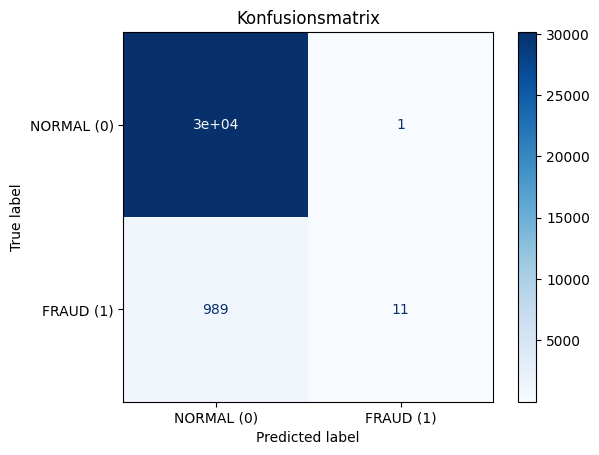


ROC-Kurve und AUC-Wert:
Area Under ROC Curve (AUC): 0.8133


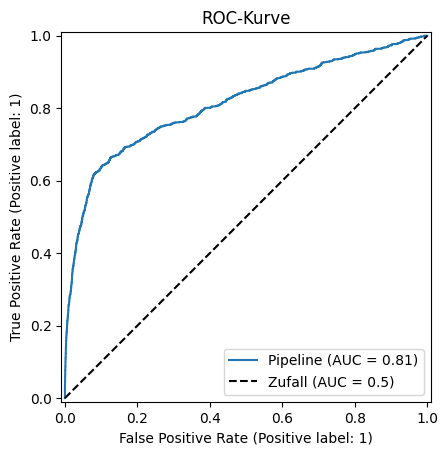

In [22]:
# 1. Vorhersagen auf dem Testset
y_pred = model_pipeline.predict(X_test)

# Für ROC/AUC benötigen wir Wahrscheinlichkeits-Scores für die positive Klasse
# Stellen Sie sicher, dass Ihr Klassifikator 'predict_proba' unterstützt
try:
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
    roc_auc_berechenbar = True
except AttributeError:
    print("Das Modell unterstützt 'predict_proba' nicht, ROC/AUC kann nicht berechnet werden.")
    roc_auc_berechenbar = False
except Exception as e:
    print(f"Fehler bei predict_proba: {e}")
    roc_auc_berechenbar = False


# 2. Klassifikationsbericht
# Definieren der Klassennamen basierend auf dem ursprünglichen Mapping {'FRAUD': 1, 'NORMAL': 0}
target_names = ['NORMAL (0)', 'FRAUD (1)'] 
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred, target_names=target_names))


# 3. Konfusionsmatrix
print("\nKonfusionsmatrix:")
cm = confusion_matrix(y_test, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp_cm.plot(cmap=plt.cm.Blues)
plt.title("Konfusionsmatrix")
plt.show()


# 4. ROC-Kurve und AUC-Wert (falls Wahrscheinlichkeiten verfügbar sind)
if roc_auc_berechenbar:
    print("\nROC-Kurve und AUC-Wert:")
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"Area Under ROC Curve (AUC): {auc_score:.4f}")

    RocCurveDisplay.from_estimator(model_pipeline, X_test, y_test)
    # Alternativ, falls from_estimator nicht direkt mit der Pipeline wie gewünscht funktioniert
    # oder man y_pred_proba verwenden möchte:
    # RocCurveDisplay.from_predictions(y_test, y_pred_proba) 
    plt.title("ROC-Kurve")
    plt.plot([0, 1], [0, 1], 'k--', label='Zufall (AUC = 0.5)') # Referenzlinie für Zufall
    plt.legend()
    plt.show()
else:
    print("\nROC-Kurve und AUC-Wert konnten nicht erstellt werden.")